In [1]:
from pyserini.ltr import *
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pyserini.search import get_topics_with_reader
fe = FeatureExtractor('indexes/msmarco-passage/lucene-index-msmarco/', 20)
fe.add(BM25(k1=0.9,b=0.4))
fe.add(BM25(k1=1.2,b=0.75))
fe.add(BM25(k1=2.0,b=0.75))
fe.add(LMDir(mu=1000))
fe.add(LMDir(mu=1500))
fe.add(LMDir(mu=2500))
fe.add(LMJM(0.1))
fe.add(LMJM(0.4))
fe.add(LMJM(0.7))
fe.add(DFR_GL2())
fe.add(DFR_In_expB2())
fe.add(DocSize())
fe.add(QueryLength())
fe.add(UniqueTermCount())
fe.add(MatchingTermCount())
fe.add(SCS())
fe.add(tfStat(AvgPooler()))
fe.add(tfStat(SumPooler()))
fe.add(tfStat(MinPooler()))
fe.add(tfStat(MaxPooler()))
fe.add(tfStat(VarPooler()))
fe.add(tfIdfStat(AvgPooler()))
fe.add(tfIdfStat(SumPooler()))
fe.add(tfIdfStat(MinPooler()))
fe.add(tfIdfStat(MaxPooler()))
fe.add(tfIdfStat(VarPooler()))
fe.add(normalizedTfStat(AvgPooler()))
fe.add(normalizedTfStat(SumPooler()))
fe.add(normalizedTfStat(MinPooler()))
fe.add(normalizedTfStat(MaxPooler()))
fe.add(normalizedTfStat(VarPooler()))
fe.add(idfStat(AvgPooler()))
fe.add(idfStat(SumPooler()))
fe.add(idfStat(MinPooler()))
fe.add(idfStat(MaxPooler()))
fe.add(idfStat(VarPooler()))
fe.add(ictfStat(AvgPooler()))
fe.add(ictfStat(SumPooler()))
fe.add(ictfStat(MinPooler()))
fe.add(ictfStat(MaxPooler()))
fe.add(ictfStat(VarPooler()))
fe.add(scqStat(AvgPooler()))
fe.add(scqStat(SumPooler()))
fe.add(scqStat(MinPooler()))
fe.add(scqStat(MaxPooler()))
fe.add(scqStat(VarPooler()))
fe.add(UnorderedSequentialPairs(3))
fe.add(UnorderedSequentialPairs(8))
fe.add(UnorderedSequentialPairs(15))
fe.add(OrderedSequentialPairs(3))
fe.add(OrderedSequentialPairs(8))
fe.add(OrderedSequentialPairs(15))
fe.add(UnorderedQueryPairs(3))
fe.add(UnorderedQueryPairs(8))
fe.add(UnorderedQueryPairs(15))
fe.add(OrderedQueryPairs(3))
fe.add(OrderedQueryPairs(8))
fe.add(OrderedQueryPairs(15))
analyzer = Analyzer(get_lucene_analyzer())

In [2]:
queries = get_topics_with_reader('io.anserini.search.topicreader.TsvIntTopicReader',
                                 'collections/msmarco-passage/queries.train.tsv')
queries.update(get_topics_with_reader('io.anserini.search.topicreader.TsvIntTopicReader',
                                 'collections/msmarco-passage/queries.dev.tsv'))

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
train = pd.read_csv('collections/msmarco-passage/qidpidtriples.train.full.tsv',sep="\t",
                    names=['qid','pos_pid','neg_pid'])
pos_half = train[['qid','pos_pid']].rename(columns={"pos_pid": "pid"}).drop_duplicates()
pos_half['rel'] = 1
neg_half = train[['qid','neg_pid']].rename(columns={"neg_pid": "pid"}).drop_duplicates()
neg_half['rel'] = 0
del train
sampled_neg_half = []
for qid, group in tqdm(neg_half.groupby('qid')):
    sampled_neg_half.append(group.sample(n=min(10,len(group)),random_state=12345))
sampled_train = pd.concat([pos_half]+sampled_neg_half,axis=0,ignore_index=True)
del pos_half,neg_half,sampled_neg_half

100%|██████████| 327721/327721 [04:05<00:00, 1332.54it/s]


In [4]:
print(sampled_train.shape)
print(sampled_train.qid.drop_duplicates().shape)
print(sampled_train.groupby('qid').count().mean()['pid'])
print(sampled_train.head(10))

(3606272, 3)
(327721,)
11.004091895240158
      qid      pid  rel
0  662731   193249    1
1  527862  1505983    1
2  984152  2304924    1
3   81644  1097740    1
4  189845  1051356    1
5  565428  7882061    1
6  250968  6670995    1
7  823523  2594522    1
8   90842  3079704    1
9  411362    31018    1


In [5]:
dev = pd.read_csv('collections/msmarco-passage/top1000.dev',sep="\t",
                    names=['qid','pid','query','doc'], usecols=['qid','pid'])
# dev = pd.read_csv('runs/msmarco-passage/run.msmarco-passage.dev.small.tsv',sep="\t",
#                     names=['qid','pid','rank'])
dev_qrel=pd.read_csv('collections/msmarco-passage/qrels.dev.small.tsv', sep="\t",
                     names=["qid","q0","pid","rel"], usecols=['qid','pid','rel'])
dev = dev.merge(dev_qrel,left_on=['qid','pid'],right_on=['qid','pid'],how='left')
dev['rel'] = dev['rel'].fillna(0).astype(np.int)
del dev_qrel

In [6]:
print(dev.shape)
print(dev.qid.drop_duplicates().shape)
print(dev.groupby('qid').count().mean()['pid'])
print(dev.head(10))

(6974598, 4)
(6980,)
999.2260744985673
       qid      pid  rank  rel
0  1048585  7187158     1    1
1  1048585  7187157     2    0
2  1048585  7187163     3    0
3  1048585  7546327     4    0
4  1048585  7187160     5    0
5  1048585  8227279     6    0
6  1048585  7617404     7    0
7  1048585  7187156     8    0
8  1048585  2298838     9    0
9  1048585  7187155    10    0


In [7]:
from tqdm import tqdm
def extract(df,analyzer):
    lines = []
    fetch_later = []
    for qid,group in tqdm(df.groupby('qid')):
        analyzed_query = analyzer.analyze(queries[qid]['title'])
        docids = [str(did) for did in group['pid'].drop_duplicates().tolist()]
        fe.lazy_extract(str(qid),analyzed_query,docids)
        fetch_later.append(str(qid))
        if len(fetch_later) == 10000:
            for qid in fetch_later:
                for doc in fe.get_result(qid):
                    lines.append((int(qid), int(doc['pid']), *doc['features']))
            fetch_later = []
    #deal with rest
    if len(fetch_later) > 0:
        for qid in fetch_later:
            for doc in fe.get_result(qid):
                lines.append((int(qid), int(doc['pid']), *doc['features']))
        fetch_later = []
    extracted = pd.DataFrame(lines, columns=['qid','pid']+fe.feature_names())
    return df.merge(extracted,how='inner',left_on=['qid','pid'],right_on=['qid','pid'])

In [8]:
import json
def export(df, analyzer, fn):
    with open(fn,'w') as f:
        for qid,group in df.groupby('qid'):
            line = {}
            line['qid'] = qid
            line['queryTokens'] = analyzer.analyze(queries[qid]['title'])
            line['docIds'] = [str(did) for did in group['pid'].drop_duplicates().tolist()]
            f.write(json.dumps(line)+'\n')

In [9]:
train_data=extract(sampled_train,analyzer)
# export(sampled_train,analyzer,'train.json')

100%|██████████| 327721/327721 [07:50<00:00, 697.16it/s] 


In [10]:
dev_data=extract(dev,analyzer)
# export(dev,analyzer,'dev.json')

100%|██████████| 6980/6980 [00:48<00:00, 144.73it/s]


In [11]:
feature_name=fe.feature_names()
train_data=train_data.sort_values(by='qid', kind='mergesort')
train_feature=train_data.loc[:,feature_name]
train_label=train_data['rel']
train_qgroup=train_data.groupby('qid').agg(count=('pid','count'))['count']
dev_data=dev_data.sort_values(by='qid', kind='mergesort')
rerank_mask = dev_data['rank'] <= 1000
dev_feature=dev_data.loc[rerank_mask, feature_name]
dev_label=dev_data.loc[rerank_mask,'rel']
dev_qgroup=dev_data.loc[rerank_mask,['qid','pid']].groupby('qid').agg(count=('pid','count'))['count']

[LightGBM] [Info] Total groups: 327721, total data: 3606272
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8317
[LightGBM] [Info] Number of data points in the train set: 3606272, number of used features: 48
[LightGBM] [Info] Total groups: 6980, total data: 6974598


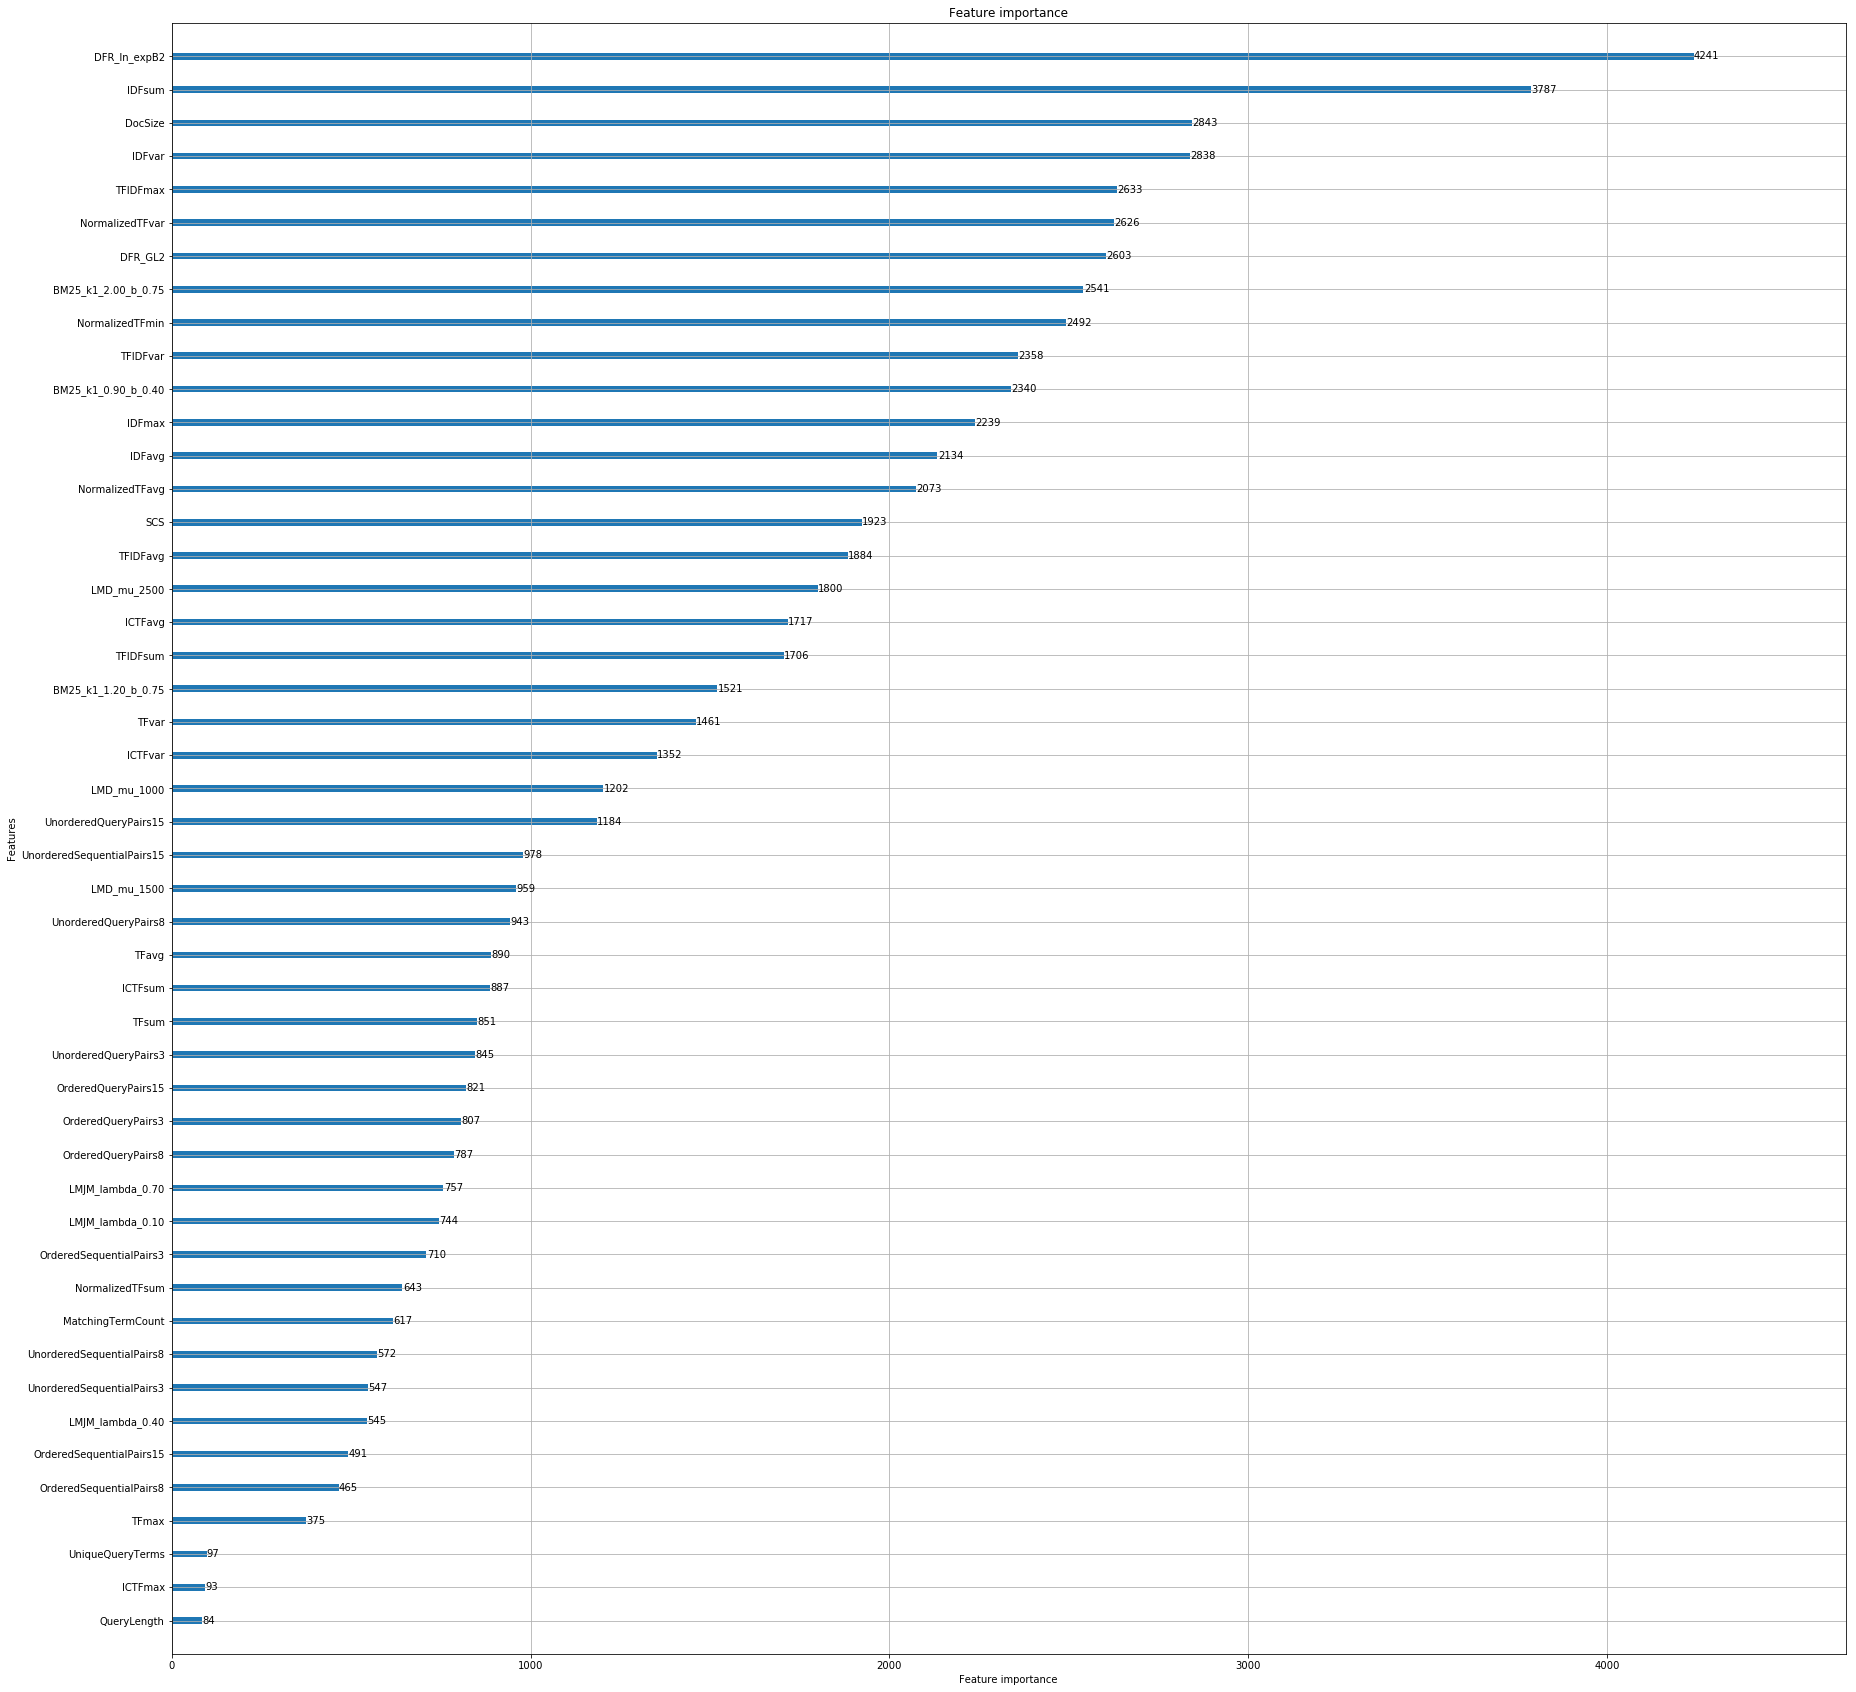

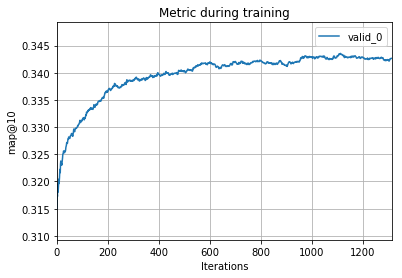

In [100]:
import lightgbm as lgb
import matplotlib.pyplot as plt
lgb_train = lgb.Dataset(train_feature,
                 weight=train_label*0+1,
                 label=train_label,
                 group=train_qgroup)
lgb_valid = lgb.Dataset(dev_feature,
                     label=dev_label,
                     group=dev_qgroup)
params = {
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'max_bin':255,
    'num_leaves':63,
    'max_depth':10,
    'min_data_in_leaf':50,
    'min_sum_hessian_in_leaf':0,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'feature_fraction':1,
    'learning_rate':0.05,
    'num_boost_round':2000,
    'early_stopping_round':200,
    'metric':['map'],
    'eval_at':[10],
    'label_gain':[0,1],
    'lambdarank_truncation_level':20,
    'seed':12345,
    'num_threads':-1
}
num_boost_round = params.pop('num_boost_round')
eval_results={}
gbm = lgb.train(params, lgb_train, 
                num_boost_round=num_boost_round,
                valid_sets=lgb_valid,
                feature_name=feature_name,
                evals_result=eval_results,
#                 feval=mrr,
                verbose_eval=False)
dev_data['score'] = -10000 - dev_data['rank']
dev_data.loc[rerank_mask,'score']=gbm.predict(dev_feature)
ax = lgb.plot_importance(gbm, importance_type='split', max_num_features=None, figsize=(30,30))
plt.show()
ax = lgb.plot_metric(eval_results, metric='map@10')
plt.show()
# ax = lgb.plot_metric(eval_results, metric='mrr@10')
# plt.show()

In [102]:
from tqdm import tqdm
with open('lambdarank.run','w') as f:
    score_tie_counter = 0
    score_tie_query = set()
    for qid, group in tqdm(dev_data.loc[rerank_mask,['qid','pid','score']].groupby('qid')):
        rank = 1
        prev_score = -1e10
        prev_pid = ''
        assert len(group['pid'].tolist()) == len(set(group['pid'].tolist()))
        for t in group.sort_values(['score'],ascending=False,kind='mergesort').itertuples():
            if abs(t.score-prev_score)<1e-8:
                score_tie_counter+=1
                score_tie_query.add(qid)
            assert prev_pid != t.pid
            prev_score = t.score
            prev_pid = t.pid
            f.write(f'{t.qid}\t{t.pid}\t{rank}\n')
            rank += 1
    if score_tie_counter>0:
        print(f'score_tie occurs {score_tie_counter} times in {len(score_tie_query)} queries')

100%|██████████| 6980/6980 [00:19<00:00, 359.27it/s]

score_tie occurs 1723734 times in 6978 queries


In [103]:
!python tools/scripts/msmarco/msmarco_eval.py collections/msmarco-passage/qrels.dev.small.tsv lambdarank.run

#####################
MRR @10: 0.21017601309864858
QueriesRanked: 6980
#####################


In [104]:
with open('lambdarank.run.trec','w') as f:
    for qid, group in tqdm(dev_data.loc[rerank_mask,['qid','pid','score']].groupby('qid')):
        rank = 1
        assert len(group['pid'].tolist()) == len(set(group['pid'].tolist()))
        for t in group.sort_values(['score'],ascending=False,kind='mergesort').itertuples():
            new_score = t.score - rank*1e-6
            f.write(f'{t.qid}\tQ0\t{t.pid}\t{rank}\t{new_score:.6f}\tlambdarank\n')
            rank+=1

100%|██████████| 6980/6980 [00:20<00:00, 334.01it/s]


In [105]:
!tools/eval/trec_eval.9.0.4/trec_eval -m all_trec collections/msmarco-passage/qrels.dev.small.tsv lambdarank.run.trec | egrep '^map\s|recall_1000'

map                   	all	0.2186
recall_1000           	all	0.8573
